# Customer segmentation

In [182]:
import pyod
from pyod.models.ecod import ECOD
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from kmodes.kprototypes import KPrototypes
import tqdm

## Create Synthetic Datasets

In [135]:
# Set seed for reproducibility
np.random.seed(42)
random.seed(42)

# Number of samples
num_samples = 1000

# Generate user_id
user_id = np.arange(1, num_samples + 1).astype(int)

# Generate age with some missing values
age = np.random.normal(loc=40, scale=10, size=num_samples).astype(int)
age = np.clip(age, 18, 85)

# Generate gender
gender = np.random.choice(['male', 'female'], size=num_samples)

# Generate location
location = np.random.choice(['Colombia', 'Venezuela', 'Peru'], size=num_samples)
#replace one value with missing value
location[random.randint(0, num_samples-1)] = None

# Generate registration date
start_date = datetime(2024, 1, 1)
end_date = datetime(2024, 6, 1)
reg_dt = [start_date + timedelta(days=np.random.randint(0, (end_date - start_date).days)) for _ in range(num_samples)]

# Generate type of account
type_of_account = np.random.choice(['basic', 'premium', 'premium_plus'], size=num_samples)

# Generate account status
account_status = np.random.choice([True, False], size=num_samples)

# Generate credit score with one invalid score
credit_score = np.random.normal(loc=700, scale=50, size=num_samples).astype(int)
credit_score = np.clip(credit_score, 350, 850)

#replace 5 values with 1500
for i in range(5):
    credit_score[random.randint(0, num_samples-1)] = 1500
    
# Generate type of vehicle
type_of_vehicle = np.random.choice(['car', 'motorcycle'], size=num_samples)

# Create DataFrame
data = pd.DataFrame({
    'user_id': user_id,
    'age': age,
    'gender': gender,
    'location': location,
    'reg_dt': reg_dt,
    'type_of_account': type_of_account,
    'account_status': account_status,
    'credit_score': credit_score,
    'type_of_vehicle': type_of_vehicle
})

# Add duplicate records
# data = pd.concat([data, data.sample(2, random_state=42)], ignore_index=False)

print(data.tail(15))


     user_id  age  gender   location     reg_dt type_of_account  \
985      986   28    male  Venezuela 2024-01-20           type3   
986      987   55  female       Peru 2024-05-02           type1   
987      988   48    male   Colombia 2024-03-07           type1   
988      989   37    male       Peru 2024-03-23           type1   
989      990   40    male   Colombia 2024-01-03           type1   
990      991   42  female   Colombia 2024-03-04           type2   
991      992   19  female   Colombia 2024-02-09           type2   
992      993   37    male   Colombia 2024-02-28           type1   
993      994   33    male  Venezuela 2024-03-02           type3   
994      995   29    male       Peru 2024-05-11           type1   
995      996   37  female       Peru 2024-02-29           type2   
996      997   57    male       Peru 2024-04-25           type3   
997      998   46  female   Colombia 2024-03-15           type2   
998      999   34    male  Venezuela 2024-05-01           type

In [136]:
data.dtypes

user_id                     int64
age                         int64
gender                     object
location                   object
reg_dt             datetime64[ns]
type_of_account            object
account_status               bool
credit_score                int64
type_of_vehicle            object
dtype: object

In [137]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random

# Set seed for reproducibility
np.random.seed(42)
random.seed(42)

# Load the previously generated user data
num_samples = 1000

# Generate the number of transactions per user
num_transactions_per_user = np.random.randint(1, 10, num_samples)

# Generate transaction data
user_ids = []
transaction_ids = []
transaction_types = []
transaction_amounts = []
transaction_dates = []

# Possible transaction types
transaction_type_choices = ['deposit', 'withdrawal', 'transfer', 'payment']

# Create transactions for each user
transaction_id = 1
for i in range(num_samples):
    user_id = i
    reg_dt = data.loc[i, 'reg_dt']
    
    for x in range(num_transactions_per_user[i]):
        user_ids.append(user_id)
        transaction_ids.append(transaction_id)
        transaction_types.append(random.choice(transaction_type_choices))
        transaction_amounts.append(round(random.uniform(1.00, 10000.00), 2))
        
        # Generate transaction date after user's reg_dt
        transaction_date = reg_dt + timedelta(days=np.random.randint(1, (datetime.today() - reg_dt).days), 
                                              seconds=np.random.randint(0, 86400))
        transaction_dates.append(transaction_date)
        
        transaction_id += 1

# Create DataFrame for transactions
transactions_df = pd.DataFrame({
    'user_id': user_ids,
    'transaction_id': transaction_ids,
    'transaction_type': transaction_types,
    'transaction_amount': transaction_amounts,
    'transaction_date': transaction_dates
})

#cast transaction date to datetime
transactions_df['transaction_date'] = pd.to_datetime(transactions_df['transaction_date'])

print(transactions_df.head(15))


    user_id  transaction_id transaction_type  transaction_amount  \
0         0               1          deposit              251.08   
1         0               2         transfer             2449.67   
2         0               3       withdrawal             7364.98   
3         0               4          deposit             5905.33   
4         0               5          deposit              298.94   
5         0               6       withdrawal             2327.38   
6         0               7          deposit             5612.89   
7         1               8          payment             2205.19   
8         1               9         transfer             8094.50   
9         1              10          deposit             7588.31   
10        1              11       withdrawal             6981.70   
11        2              12         transfer             2779.44   
12        2              13       withdrawal             9572.17   
13        2              14         transfer    

In [138]:
transactions_df.dtypes

user_id                        int64
transaction_id                 int64
transaction_type              object
transaction_amount           float64
transaction_date      datetime64[ns]
dtype: object

## Data Cleaning - User Data

### Duplicates
We will want to drop duplicate values. It is important to think about if in your data you want to consider two records duplicates  if they are exactly the same, or if you want to consider them duplicates if they are the same in some subset of columns.

In [139]:
data = data.drop_duplicates().reset_index(drop=True)

### Irrelevant Columns and Observations

Drop irrelevant observations and columns, e.g. drop columns where account_status is False which means closed, and drop type_of_vehicle


In [140]:
data = data[data['account_status'] == True].drop(columns=['type_of_vehicle', 'account_status'])

### Missing Values

Investigate missing values 

In [141]:
print(data.isnull().sum())

user_id            0
age                0
gender             0
location           0
reg_dt             0
type_of_account    0
credit_score       0
dtype: int64


Several options to handle  missings: if you have a lot of data and only a few missings, you can drop them, 
otherwise you can impute the missings in several ways including using the mean, median, or mode, you could draw a random value from the distribution, 
or you could use a machine learning model to predict the missing value. I am simply going to fill the missing values in age with the mean.

In [142]:
data['age'] = data['age'].fillna(data['age'].mean())

### Outliers



In [143]:
data['credit_score'].describe()

count     498.000000
mean      701.742972
std        79.598554
min       554.000000
25%       663.250000
50%       695.000000
75%       733.750000
max      1500.000000
Name: credit_score, dtype: float64

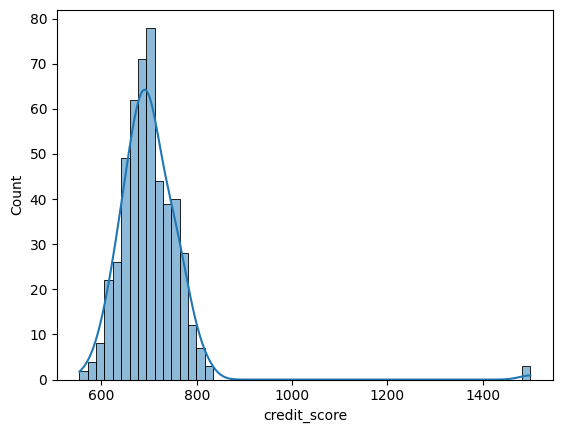

In [144]:
#plot the distribution of credit score as histogram
sns.histplot(data['credit_score'], kde=True)
plt.show()

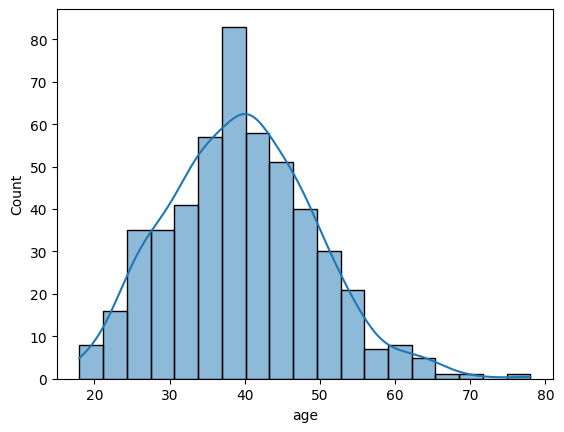

In [145]:
#plot the distribution of age as histogram
sns.histplot(data['age'], kde=True)
plt.show()

In [146]:
#calculate outliers using 3 sd for credit score
for var in ['credit_score', 'age']:
    mean = data[var].mean()
    sd = data[var].std()
    data['outliers'] = (data[var] - mean).abs() > 3*sd
    print("The variable", var, "has" ,data['outliers'].sum(), "outlier(s).")

The variable credit_score has 3 outlier(s).
The variable age has 2 outlier(s).


In [147]:
#Lets go ahead and just drop these observations as they are only a few observations. 
print("Data has", data.shape[0], "observations to begin.")
data['outliers'] = False
for var in ['credit_score', 'age']:
    mean = data[var].mean()
    sd = data[var].std()
    data['outliers'] = data['outliers'] | ((data[var] - mean).abs() > 3*sd)
#drop outliers
data = data[data['outliers'] == False].drop(columns=['outliers'])
print("Data now has", data.shape[0], "observations after dropping the outliers .")

Data has 498 observations to begin.
Data now has 493 observations after dropping the outliers .


## Data Cleaning - Transaction Data

### Duplicates
We will want to drop duplicate values. It is important to think about if in your data you want to consider two records duplicates  if they are exactly the same, or if you want to consider them duplicates if they are the same in some subset of columns.

In [148]:
print("Transaction data has", transactions_df.shape[0], "records to start.")
transactions_df = transactions_df.drop_duplicates(subset=['transaction_id', 'user_id']).reset_index(drop=True)
print("Transaction data has", transactions_df.shape[0], "records after dropping duplicates.")

Transaction data has 4898 records to start.
Transaction data has 4898 records after dropping duplicates.


### Missing Values

Investigate missing values 

In [149]:
print(transactions_df.isnull().sum())

user_id               0
transaction_id        0
transaction_type      0
transaction_amount    0
transaction_date      0
dtype: int64


### Outliers



In [150]:
transactions_df['transaction_amount'].describe()

count    4898.000000
mean     4970.474857
std      2869.846510
min         2.960000
25%      2487.475000
50%      4940.100000
75%      7459.567500
max      9999.080000
Name: transaction_amount, dtype: float64

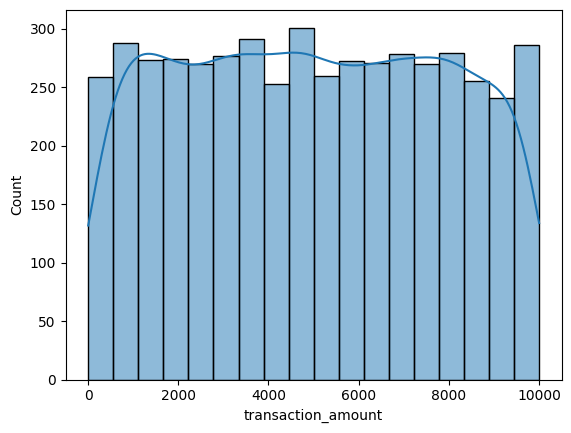

In [151]:
#plot the distribution of credit score as histogram
sns.histplot(transactions_df['transaction_amount'], kde=True)
plt.show()

The distribution in the graph looks pretty good with no noticeable outliers, however lets double check for outiers statistically. 

In [152]:
#calculate outliers using 3 sd for transaction amounts
for var in ['transaction_amount']:
    mean = transactions_df[var].mean()
    sd = transactions_df[var].std()
    transactions_df['outliers'] = (transactions_df[var] - mean).abs() > 3*sd
    print("The variable", var, "has" ,transactions_df['outliers'].sum(), "outlier(s).")

The variable transaction_amount has 0 outlier(s).


There are no outliers as defined by this statistical method. 

## Feature Engineering

### User Data

In [155]:
# extract the object columns
obj_cols = data.select_dtypes(include=['object']).columns.tolist()
encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = encoder.fit_transform(data[obj_cols])
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(obj_cols))

# Concatenate the one-hot encoded dataframe with the original dataframe
df_encoded = pd.concat([data, one_hot_df], axis=1)

# Drop the original categorical columns
df_encoded = df_encoded.drop(obj_cols, axis=1)

# Display the resulting dataframe
df_encoded.head()

,user_id,age,reg_dt,credit_score,gender_female,gender_male,location_Colombia,location_None,location_Peru,location_Venezuela,type_of_account_type1,type_of_account_type2,type_of_account_type3
0,1.0,44.0,2024-02-23,732.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,4.0,55.0,2024-05-28,822.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,5.0,37.0,2024-05-18,680.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
5,6.0,37.0,2024-01-05,669.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
6,7.0,55.0,2024-01-20,790.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


### Transaction Data: One record
For this model, we need our data such that we only have one record per person, thus we need to convert our transaction data features into features with multiple records per person to one per person. 

In [156]:
transactions_df.dtypes

user_id                        int64
transaction_id                 int64
transaction_type              object
transaction_amount           float64
transaction_date      datetime64[ns]
outliers                        bool
dtype: object

Let's create the number of transactions.

In [157]:
#Count the number of transactions per user and add to the transactions dataframe
num_transactions = transactions_df.groupby('user_id').size().reset_index(name='num_transactions')
transactions_df = pd.merge(transactions_df, num_transactions, on='user_id')
transactions_df.head(15)

,user_id,transaction_id,transaction_type,transaction_amount,transaction_date,outliers,num_transactions
0,0,1,deposit,251.08,2024-05-05 15:39:33,False,7
1,0,2,transfer,2449.67,2024-04-30 11:06:26,False,7
2,0,3,withdrawal,7364.98,2024-05-30 23:46:35,False,7
3,0,4,deposit,5905.33,2024-03-02 18:02:09,False,7
4,0,5,deposit,298.94,2024-03-29 09:41:51,False,7
5,0,6,withdrawal,2327.38,2024-05-21 08:50:21,False,7
6,0,7,deposit,5612.89,2024-03-26 16:48:55,False,7
7,1,8,payment,2205.19,2024-04-02 23:27:38,False,4
8,1,9,transfer,8094.50,2024-07-09 15:12:51,False,4
9,1,10,deposit,7588.31,2024-07-30 18:25:58,False,4


Time since last transaction

In [158]:
#Calculate the number of days between last transaction and current date
transactions_df['days_since_last_transaction'] = (datetime.today() - transactions_df.groupby('user_id')['transaction_date'].transform('max')).dt.days
transactions_df.head(15)

,user_id,transaction_id,transaction_type,transaction_amount,transaction_date,outliers,num_transactions,days_since_last_transaction
0,0,1,deposit,251.08,2024-05-05 15:39:33,False,7,61
1,0,2,transfer,2449.67,2024-04-30 11:06:26,False,7,61
2,0,3,withdrawal,7364.98,2024-05-30 23:46:35,False,7,61
3,0,4,deposit,5905.33,2024-03-02 18:02:09,False,7,61
4,0,5,deposit,298.94,2024-03-29 09:41:51,False,7,61
5,0,6,withdrawal,2327.38,2024-05-21 08:50:21,False,7,61
6,0,7,deposit,5612.89,2024-03-26 16:48:55,False,7,61
7,1,8,payment,2205.19,2024-04-02 23:27:38,False,4,1
8,1,9,transfer,8094.50,2024-07-09 15:12:51,False,4,1
9,1,10,deposit,7588.31,2024-07-30 18:25:58,False,4,1


Total transaction amount per user

In [159]:
#Calculate the total transaction amount per user
total_transaction_amount = transactions_df.groupby('user_id')['transaction_amount'].sum().reset_index(name='total_transaction_amount')
transactions_df = pd.merge(transactions_df, total_transaction_amount, on='user_id')
transactions_df.head(15)

,user_id,transaction_id,transaction_type,transaction_amount,transaction_date,outliers,num_transactions,days_since_last_transaction,total_transaction_amount
0,0,1,deposit,251.08,2024-05-05 15:39:33,False,7,61,24210.27
1,0,2,transfer,2449.67,2024-04-30 11:06:26,False,7,61,24210.27
2,0,3,withdrawal,7364.98,2024-05-30 23:46:35,False,7,61,24210.27
3,0,4,deposit,5905.33,2024-03-02 18:02:09,False,7,61,24210.27
4,0,5,deposit,298.94,2024-03-29 09:41:51,False,7,61,24210.27
5,0,6,withdrawal,2327.38,2024-05-21 08:50:21,False,7,61,24210.27
6,0,7,deposit,5612.89,2024-03-26 16:48:55,False,7,61,24210.27
7,1,8,payment,2205.19,2024-04-02 23:27:38,False,4,1,24869.70
8,1,9,transfer,8094.50,2024-07-09 15:12:51,False,4,1,24869.70
9,1,10,deposit,7588.31,2024-07-30 18:25:58,False,4,1,24869.70


Average transaction amount per user

In [160]:
#Calculate the average transaction amount per user
average_transaction_amount = transactions_df.groupby('user_id')['transaction_amount'].mean().reset_index(name='average_transaction_amount')
transactions_df = pd.merge(transactions_df, average_transaction_amount, on='user_id')
transactions_df.head(15)

,user_id,transaction_id,transaction_type,transaction_amount,transaction_date,outliers,num_transactions,days_since_last_transaction,total_transaction_amount,average_transaction_amount
0,0,1,deposit,251.08,2024-05-05 15:39:33,False,7,61,24210.27,3458.61000
1,0,2,transfer,2449.67,2024-04-30 11:06:26,False,7,61,24210.27,3458.61000
2,0,3,withdrawal,7364.98,2024-05-30 23:46:35,False,7,61,24210.27,3458.61000
3,0,4,deposit,5905.33,2024-03-02 18:02:09,False,7,61,24210.27,3458.61000
4,0,5,deposit,298.94,2024-03-29 09:41:51,False,7,61,24210.27,3458.61000
5,0,6,withdrawal,2327.38,2024-05-21 08:50:21,False,7,61,24210.27,3458.61000
6,0,7,deposit,5612.89,2024-03-26 16:48:55,False,7,61,24210.27,3458.61000
7,1,8,payment,2205.19,2024-04-02 23:27:38,False,4,1,24869.70,6217.42500
8,1,9,transfer,8094.50,2024-07-09 15:12:51,False,4,1,24869.70,6217.42500
9,1,10,deposit,7588.31,2024-07-30 18:25:58,False,4,1,24869.70,6217.42500


Number of unique transaction_type per user

In [161]:
#Calculate the number of unique transaction_type per user
num_unique_transaction_types = transactions_df.groupby('user_id')['transaction_type'].nunique().reset_index(name='num_unique_transaction_types')
transactions_df = pd.merge(transactions_df, num_unique_transaction_types, on='user_id')
transactions_df.head(15)

,user_id,transaction_id,transaction_type,transaction_amount,transaction_date,outliers,num_transactions,days_since_last_transaction,total_transaction_amount,average_transaction_amount,num_unique_transaction_types
0,0,1,deposit,251.08,2024-05-05 15:39:33,False,7,61,24210.27,3458.61000,3
1,0,2,transfer,2449.67,2024-04-30 11:06:26,False,7,61,24210.27,3458.61000,3
2,0,3,withdrawal,7364.98,2024-05-30 23:46:35,False,7,61,24210.27,3458.61000,3
3,0,4,deposit,5905.33,2024-03-02 18:02:09,False,7,61,24210.27,3458.61000,3
4,0,5,deposit,298.94,2024-03-29 09:41:51,False,7,61,24210.27,3458.61000,3
5,0,6,withdrawal,2327.38,2024-05-21 08:50:21,False,7,61,24210.27,3458.61000,3
6,0,7,deposit,5612.89,2024-03-26 16:48:55,False,7,61,24210.27,3458.61000,3
7,1,8,payment,2205.19,2024-04-02 23:27:38,False,4,1,24869.70,6217.42500,4
8,1,9,transfer,8094.50,2024-07-09 15:12:51,False,4,1,24869.70,6217.42500,4
9,1,10,deposit,7588.31,2024-07-30 18:25:58,False,4,1,24869.70,6217.42500,4


In [162]:
#Keep only the necessary columns and drop duplicates
transactions_df = transactions_df[['user_id', 'num_transactions', 'days_since_last_transaction', 'total_transaction_amount', 'average_transaction_amount', 'num_unique_transaction_types']].drop_duplicates()
print(transactions_df.head(15))
print(transactions_df.shape)

    user_id  num_transactions  days_since_last_transaction  \
0         0                 7                           61   
7         1                 4                            1   
11        2                 8                           26   
19        3                 5                           22   
24        4                 7                            1   
31        5                 3                           21   
34        6                 7                           27   
41        7                 8                           22   
49        8                 5                           11   
54        9                 4                           30   
58       10                 8                           42   
66       11                 8                            4   
74       12                 3                           17   
77       13                 6                           16   
83       14                 5                           18   

    tot

## Outliers

In [163]:
# Outliers
for var in ['num_transactions', 'days_since_last_transaction', 'total_transaction_amount', 'average_transaction_amount']:
    mean = transactions_df[var].mean()
    sd = transactions_df[var].std()
    transactions_df['outliers'] = (transactions_df[var] - mean).abs() > 3*sd
    print("The variable", var, "has" ,transactions_df['outliers'].sum(), "outlier(s).")

The variable num_transactions has 0 outlier(s).
The variable days_since_last_transaction has 19 outlier(s).
The variable total_transaction_amount has 1 outlier(s).
The variable average_transaction_amount has 1 outlier(s).


In [164]:
#Lets go ahead and just drop these observations as they are only a few observations. 
print("Data has", transactions_df.shape[0], "observations to begin.")
transactions_df['outliers'] = False
for var in ['num_transactions', 'days_since_last_transaction', 'total_transaction_amount', 'average_transaction_amount']:
    mean = transactions_df[var].mean()
    sd = transactions_df[var].std()
    transactions_df['outliers'] = transactions_df['outliers'] | ((transactions_df[var] - mean).abs() > 3*sd)
#drop outliers
transactions_df = transactions_df[transactions_df['outliers'] == False].drop(columns=['outliers'])
print("Data now has", transactions_df.shape[0], "observations after dropping the outliers .")

Data has 1000 observations to begin.
Data now has 979 observations after dropping the outliers .


## Combine Datasets

In [176]:
# Merge the data and transactions dataframes
df_analysis_kmeans = pd.merge(df_encoded, transactions_df, on='user_id', how='inner')
df_analysis_kmeans.drop(columns=['reg_dt'], inplace=True)
print(df_analysis_kmeans.shape)
print(df_analysis_kmeans.head(15))

(479, 17)
    user_id   age  credit_score  gender_female  gender_male  \
0       1.0  44.0         732.0            0.0          1.0   
1       4.0  55.0         822.0            0.0          1.0   
2       5.0  37.0         680.0            0.0          1.0   
3       6.0  37.0         669.0            0.0          1.0   
4       7.0  55.0         790.0            0.0          1.0   
5       8.0  47.0         626.0            0.0          1.0   
6      10.0  45.0         705.0            0.0          1.0   
7      13.0  42.0         749.0            1.0          0.0   
8      14.0  20.0         654.0            1.0          0.0   
9      16.0  34.0         681.0            1.0          0.0   
10     18.0  43.0         696.0            0.0          1.0   
11     19.0  30.0         742.0            0.0          1.0   
12     20.0  25.0         806.0            0.0          1.0   
13     22.0  37.0         574.0            0.0          1.0   
14     33.0  39.0         671.0            1.

In [177]:
# Merge the data and transactions dataframes
df_analysis_kproto = pd.merge(data, transactions_df, on='user_id', how='inner')
df_analysis_kproto.drop(columns=['reg_dt'], inplace=True)
print(df_analysis_kproto.shape)
print(df_analysis_kproto.head(15))

(479, 11)
    user_id  age  gender   location type_of_account  credit_score  \
0         1   44    male       Peru           type3           732   
1         4   55  female       Peru           type2           822   
2         5   37    male       Peru           type2           680   
3         6   37    male   Colombia           type1           669   
4         7   55    male   Colombia           type1           790   
5         8   47    male   Colombia           type3           626   
6        10   45    male       Peru           type1           705   
7        13   42    male       Peru           type1           749   
8        14   20    male       Peru           type2           654   
9        16   34    male       Peru           type1           681   
10       18   43  female       Peru           type2           696   
11       19   30  female  Venezuela           type3           742   
12       20   25  female   Colombia           type2           806   
13       22   37  female

## K-means

## K-Prototype

In [178]:
df_analysis_kproto.dtypes

user_id                           int64
age                               int64
gender                           object
location                         object
type_of_account                  object
credit_score                      int64
num_transactions                  int64
days_since_last_transaction       int64
total_transaction_amount        float64
average_transaction_amount      float64
num_unique_transaction_types      int64
dtype: object

In [180]:
categorical_columns = [2,3,4] 
kproto = KPrototypes(n_clusters= 15, init='Cao', n_jobs = 4)
clusters = kproto.fit_predict(df_analysis_kproto, categorical=categorical_columns)
pd.Series(clusters).value_counts()

3     51
4     46
5     46
7     44
0     41
12    35
2     33
6     32
9     31
1     26
10    25
14    23
8     21
13    20
11     5
Name: count, dtype: int64

### Elbow Graph

In [ ]:
costs = []
n_clusters = []
clusters_assigned = []

for i in tqdm(range(2, 25)):
    try:
        kproto = KPrototypes(n_clusters= i, init='Cao', verbose=2)
        clusters = kproto.fit_predict(df_analysis_kproto, categorical=[0, 6, 7, 9, 13])
        costs.append(kproto.cost_)
        n_clusters.append(i)
        clusters_assigned.append(clusters)
    except:
        print(f"Can't cluster with {i} clusters")

fig = go.Figure(data=go.Scatter(x=n_clusters, y=costs ))
fig.show()

### Visualizations

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches((20, 10))
scatter = ax.scatter(embedding[:, 0], embedding[:, 1], s=2, c=clusters, cmap='tab20b', alpha=1.0)

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(num=15),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)